# Execute DYN3D after reading & writing cross sections

This Notebook demonestrates how to read cross sections from a serpent ``_res.m`` file, and write these cross sections using a template file.
In addition, this notebook shows how to execute DYN3D using the written cross sections.

## Case Description

The ``.\inputs`` directory includes:
- ``bwr_rho1_2gr`` a serpent input file. This is a 3D BWR assembly divided into 36 layers (i.e., universes 1,2,...,36) of fuel surrounded by a bottom (universe 54) and upper layers (universe 55) of reflectors.
- ``bwr_rho1_2gr_res.m`` a serpent results file with all the cross sections.
- ``univs`` a file that describes how to read ``bwr_rho1_2gr_res.m``
- ``template_dyn3d_2g`` is a template file that specifies how cross sections should be printed out.
- ``controlDict`` the main files that is required by the ``xsInterface``.

The ``.\dyn3d`` includes a pre-generated DYN3D case. The ``.\dyn3d\xs`` directory will include all the files with printed cross sections required by DYN3D.

### Required imports

In [1]:
from xsInterface.functions.main import Main

In [2]:
# a class required to execute DYN3D
from xsInterface.functions.dyn3d import DYN3D

In [3]:
# plotting capability
from xsInterface.functions.plotters import Plot1d

In [4]:
inputFile = ".\\inputs\\controlDict"

### Read the cross sections

In [5]:
# Reset the main object
xs = Main(inputFile)

... Reading control dict ...
<.\inputs\controlDict>



#### Read xs data without populating the templates

In [6]:
# readTemplate allows to read and populate data using the templates
xs.Read(readUniverses=True)

SERPENT Serpent 2.1.32 found in .\inputs\bwr_rho1_2gr_res.m, but version 2.1.31 is defined in settings
  Attemping to read anyway. Please report strange behaviors/failures to developers.


... Reading universe <u> ...
... Reading coe/_res.m file for hisotry <nom> ...


### Populate cross sections

In the ``".\\inputs\\controlDict"`` the user defined the core map used to populate the cross sections according to their channels and layers positions.

In our problem we have 1 channel and 38 axial layers.

**Define states**
These states must exist and be used to obtain the cross sections for different channels and layers.

In [7]:
nchs, nlayers = 1, 38
states = {
'history':[['nom']*nlayers]*nchs, 'time': [[0.0]*nlayers]*nchs, 'dens': [[700.]*nlayers]*nchs,}

**Populate core data**
built-in capability to populate the data according to the defined map including defining new variables not listed in the original ``univs`` file.
This is a **mandaory** step if the intent is to execute DYN3D.

In [8]:
volmanip = {'infflx': 'divide'}
xs.PopulateCoreData(
                    states=states, 
                    attributes=None,  # specify only if specific attrs needed
                    volManip=volmanip,
                    adf=None, topadf=None, bottomadf=None)

### Execute DYN3D

In [9]:
casedir = ".\\dyn3d"   # dyn3d dir
casefile = "bwr"  # name of dyn3d file
exefile = "RUN_DYN3D" # dyn3d executuin file

# Reset the object
reslt = DYN3D(xs, casedir, casefile, exefile)

**Execute**

The files will be written to the specified directories and then automatically executed.

In [10]:
reslt.Execute()



... Writing cross sections ...


... DYN3D Execution ... Start
... DYN3D Execution ... Ended Successfully


### Process results

In [11]:
# eigenvalue
reslt.keff

1.358136

In [12]:
# few-group flux
reslt.flux

array([[[1.75756027e-03, 1.08768465e-03],
        [9.17626016e-03, 1.87150819e-03],
        [1.60580237e-02, 2.97127822e-03],
        [2.25582343e-02, 4.16427836e-03],
        [2.86026533e-02, 5.26059543e-03],
        [3.40548884e-02, 6.26368238e-03],
        [3.88372478e-02, 7.13383010e-03],
        [4.28772194e-02, 7.86240617e-03],
        [4.61091966e-02, 8.44768409e-03],
        [4.84934704e-02, 8.86376663e-03],
        [5.00024171e-02, 9.13827752e-03],
        [5.06619338e-02, 9.22114873e-03],
        [5.04288585e-02, 9.17108071e-03],
        [4.93601652e-02, 8.96044971e-03],
        [4.74886570e-02, 8.61515300e-03],
        [4.48523166e-02, 8.11447277e-03],
        [4.14960325e-02, 7.50675055e-03],
        [3.75423852e-02, 6.69875624e-03],
        [3.32365352e-02, 5.73365193e-03],
        [2.88529934e-02, 4.81343619e-03],
        [2.46162027e-02, 3.97091220e-03],
        [2.06953585e-02, 3.23543021e-03],
        [1.71750585e-02, 2.59490480e-03],
        [1.40812000e-02, 2.0648743

### Compare results against Serpent

In [13]:
import numpy as np

The layers are defined as they were used in the actual problem

In [14]:
layers = np.linspace(0, 365.76, 37)  #active core
layers = np.hstack((-20.0, layers, 385.76))  # with reflectors
zmid = 0.5*(layers[0:-1] + layers[1:])

Built-in plotting capability to plot channels results

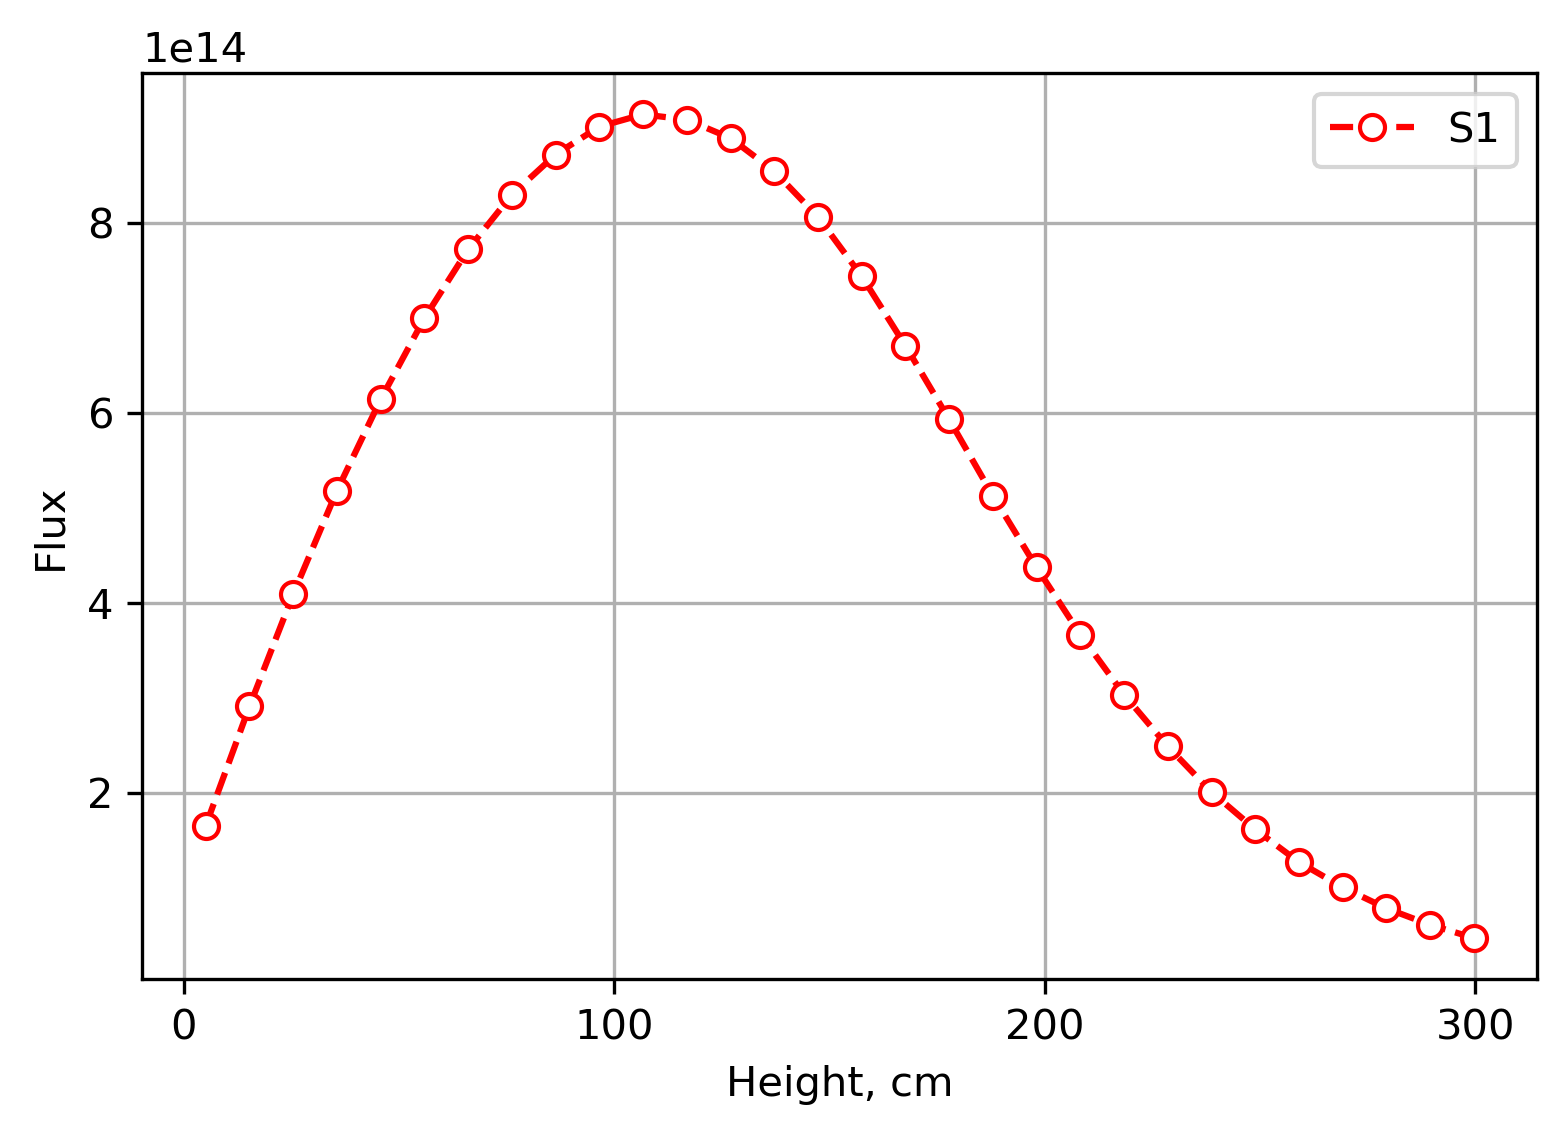

In [15]:
xs.ChannelsPlot('infflx', zmid, ylabel='Flux', xlabel='Height, cm', markers='--ro',
                layers=np.linspace(1,30,30, dtype=int), markerfill=True)

**Reference** Serpent soslution

In [16]:
refFlx, chIds = xs.CoreValues('infflx', volManip=['divide'])
refFlx = np.array(refFlx['infflx'])
# normalize to unity
refFlx = refFlx / refFlx.sum()

In [17]:
# flux obtained by DYN3D
dynFlux = np.array(reslt.flux)
dynFlux = dynFlux / dynFlux.sum()

In [18]:
dynFlux[0, :, 0]  # e.g., DYN3D flux [channel, layer, group]

array([1.75756027e-03, 9.17626016e-03, 1.60580237e-02, 2.25582343e-02,
       2.86026533e-02, 3.40548884e-02, 3.88372478e-02, 4.28772194e-02,
       4.61091966e-02, 4.84934704e-02, 5.00024171e-02, 5.06619338e-02,
       5.04288585e-02, 4.93601652e-02, 4.74886570e-02, 4.48523166e-02,
       4.14960325e-02, 3.75423852e-02, 3.32365352e-02, 2.88529934e-02,
       2.46162027e-02, 2.06953585e-02, 1.71750585e-02, 1.40812000e-02,
       1.14224153e-02, 9.17108071e-03, 7.28921362e-03, 5.73883138e-03,
       4.47677189e-03, 3.46332604e-03, 2.65533173e-03, 2.01480632e-03,
       1.50722015e-03, 1.10322300e-03, 7.80370572e-04, 5.19671554e-04,
       2.96955174e-04, 6.04269249e-05])

In [19]:
flx_g1 = {'Serpent': refFlx[0, :, 0],  # fast flux
          'DYN3D': dynFlux[0, :, 0],}
flx_g2 = {'Serpent': refFlx[0, :, 1],  # thermal flux
          'DYN3D': dynFlux[0, :, 1],}


Built-in 1-dim plotting capability

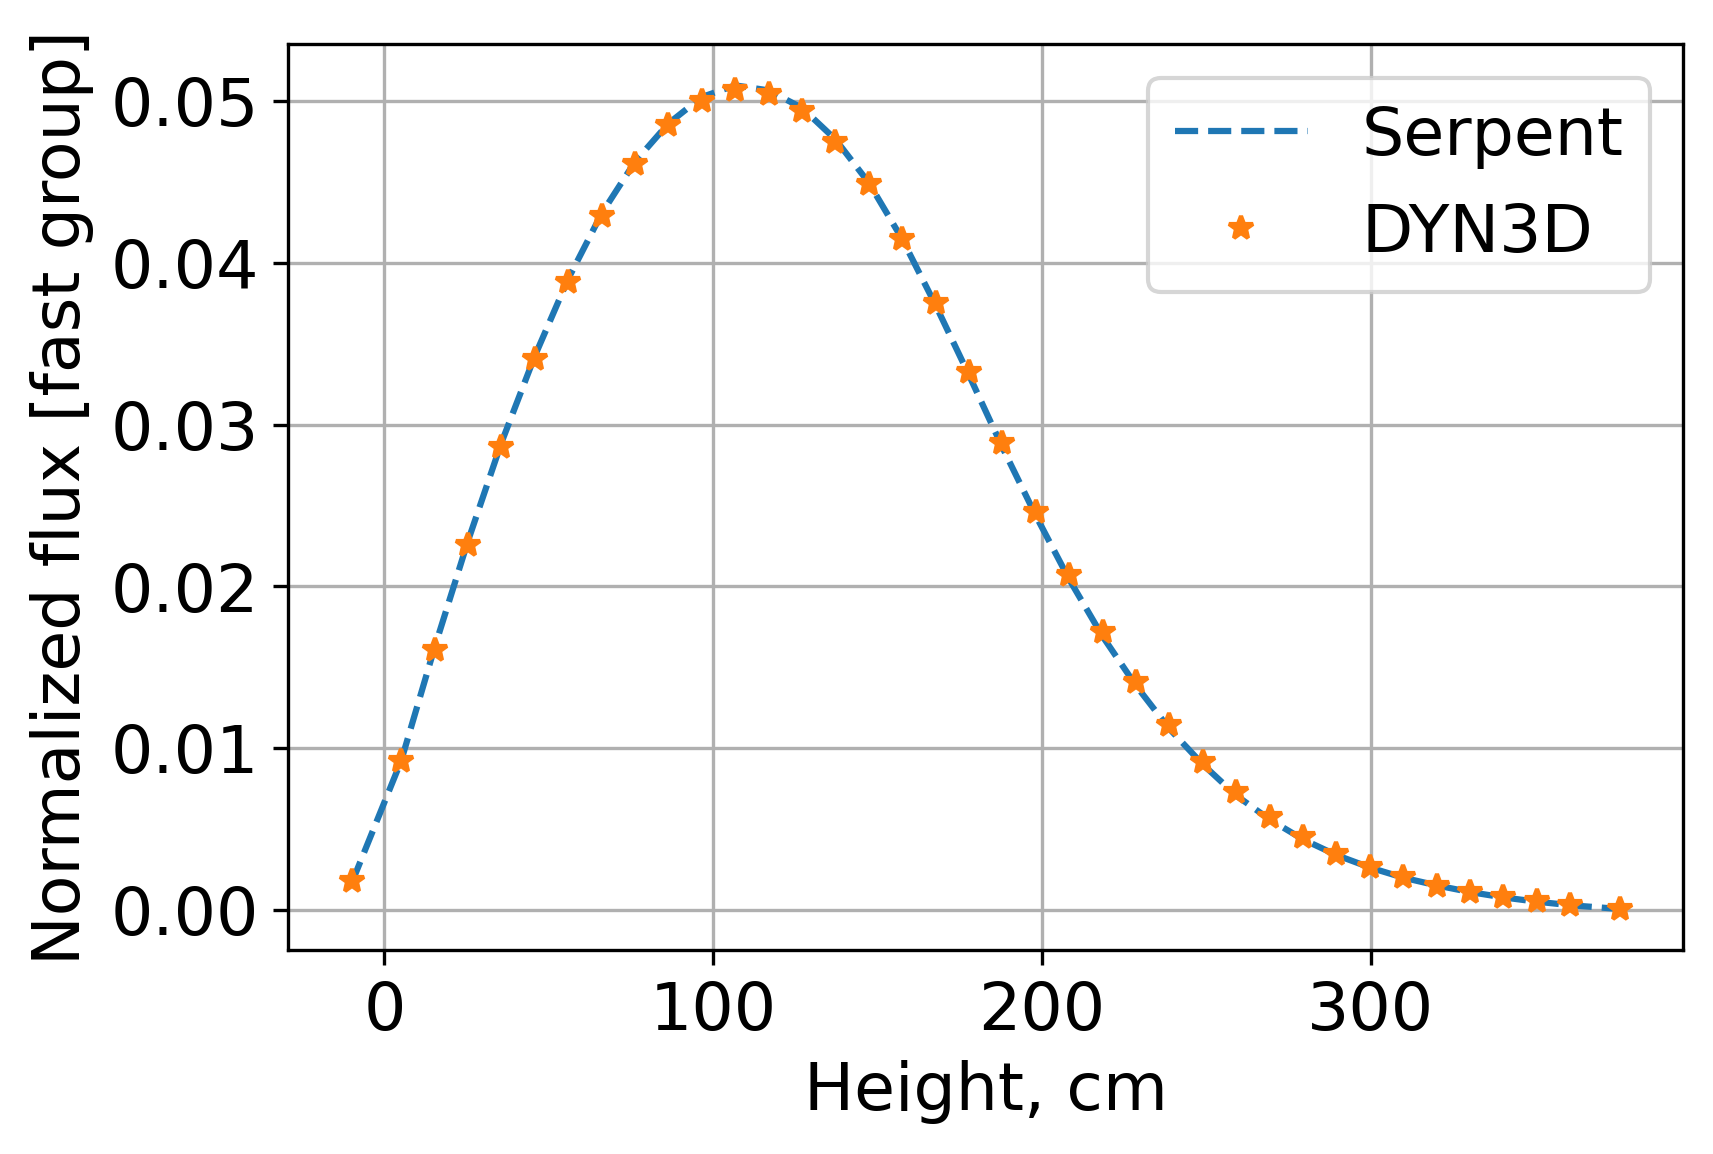

In [20]:
Plot1d(xvalues=zmid, yvalues=flx_g1,
       markers=['--', '*'],
       xlabel="Height, cm", ylabel="Normalized flux [fast group]")

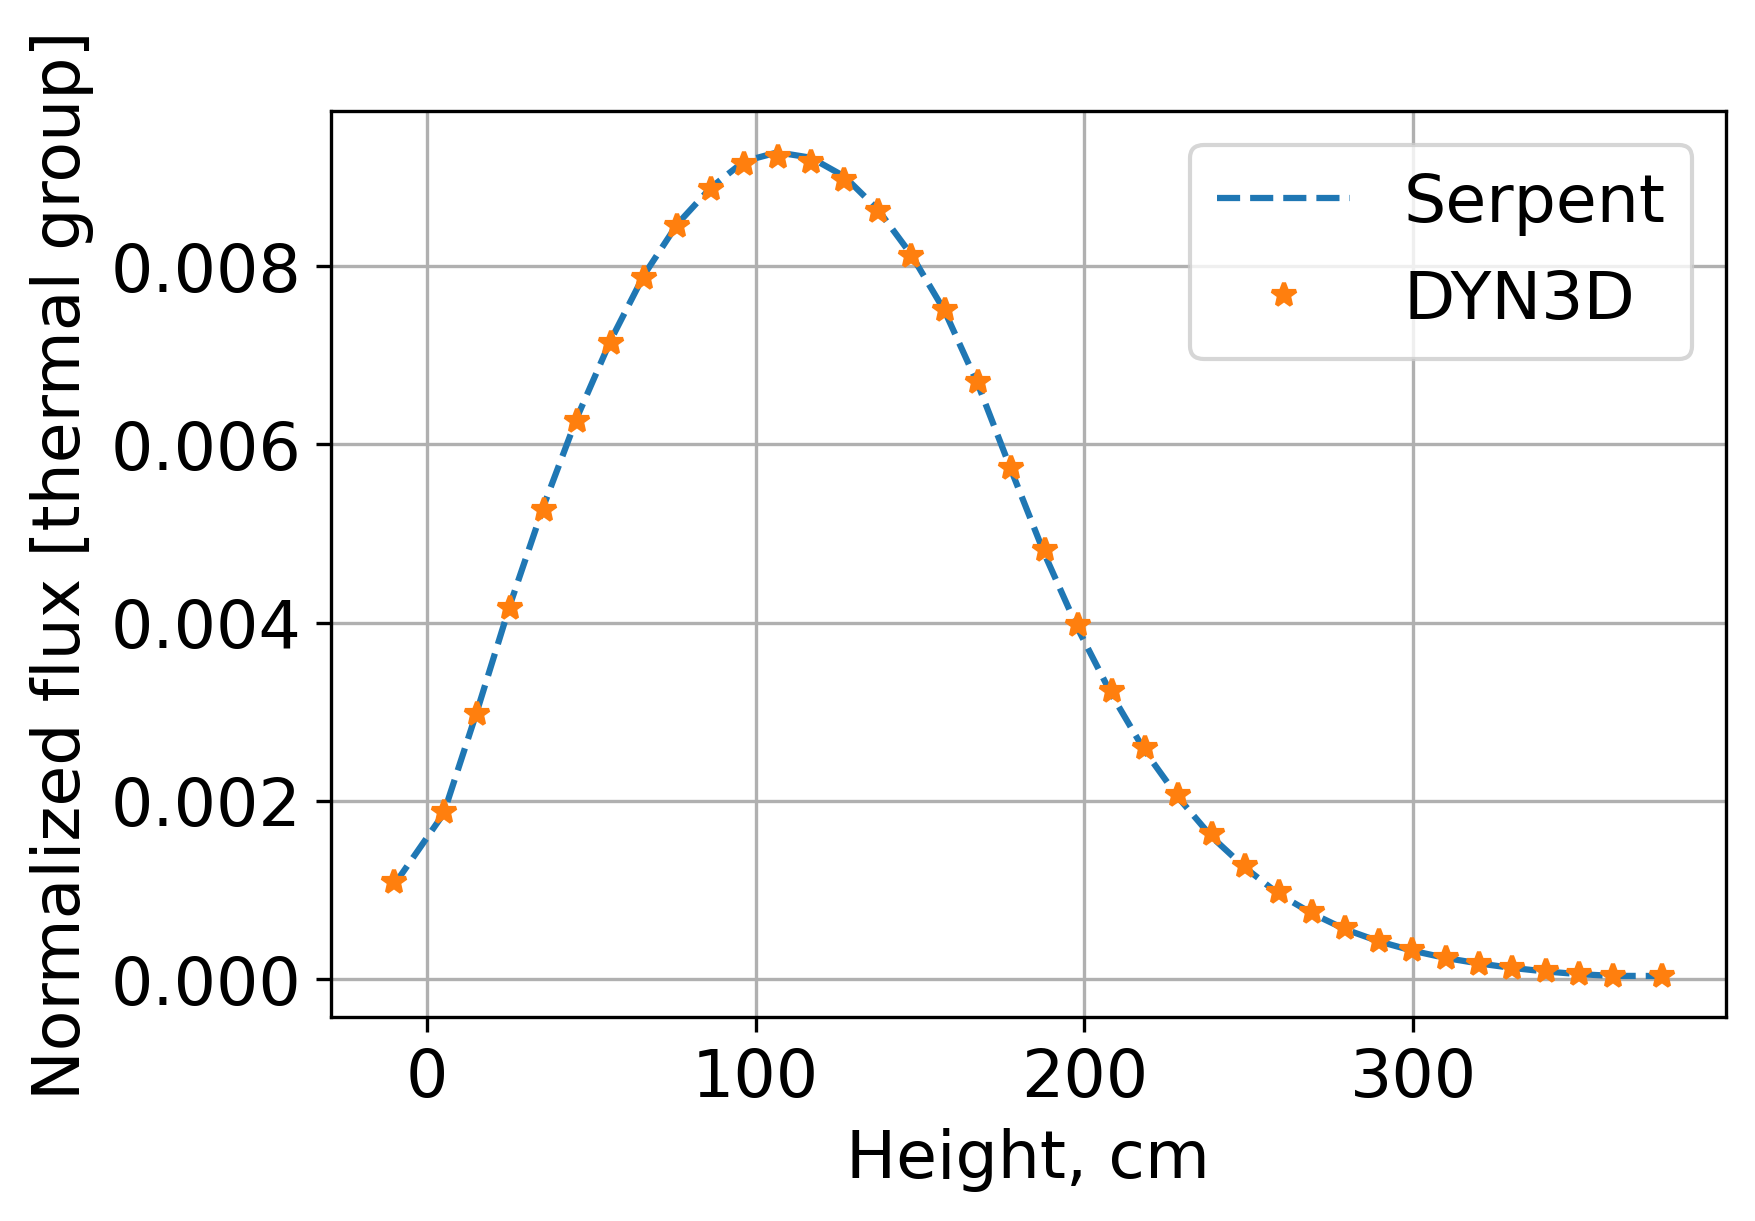

In [21]:
Plot1d(xvalues=zmid, yvalues=flx_g2,
       markers=['--', '*'],
       xlabel="Height, cm", ylabel="Normalized flux [thermal group]")

Calculate the fast and thermal flux differences and plot these

In [22]:
perc_diff = 100*(1-dynFlux/refFlx)
gr_diff = {'Fast': perc_diff[0, :, 0],  # fast flux
          'Thermal': perc_diff[0, :, 1],}  # thermal

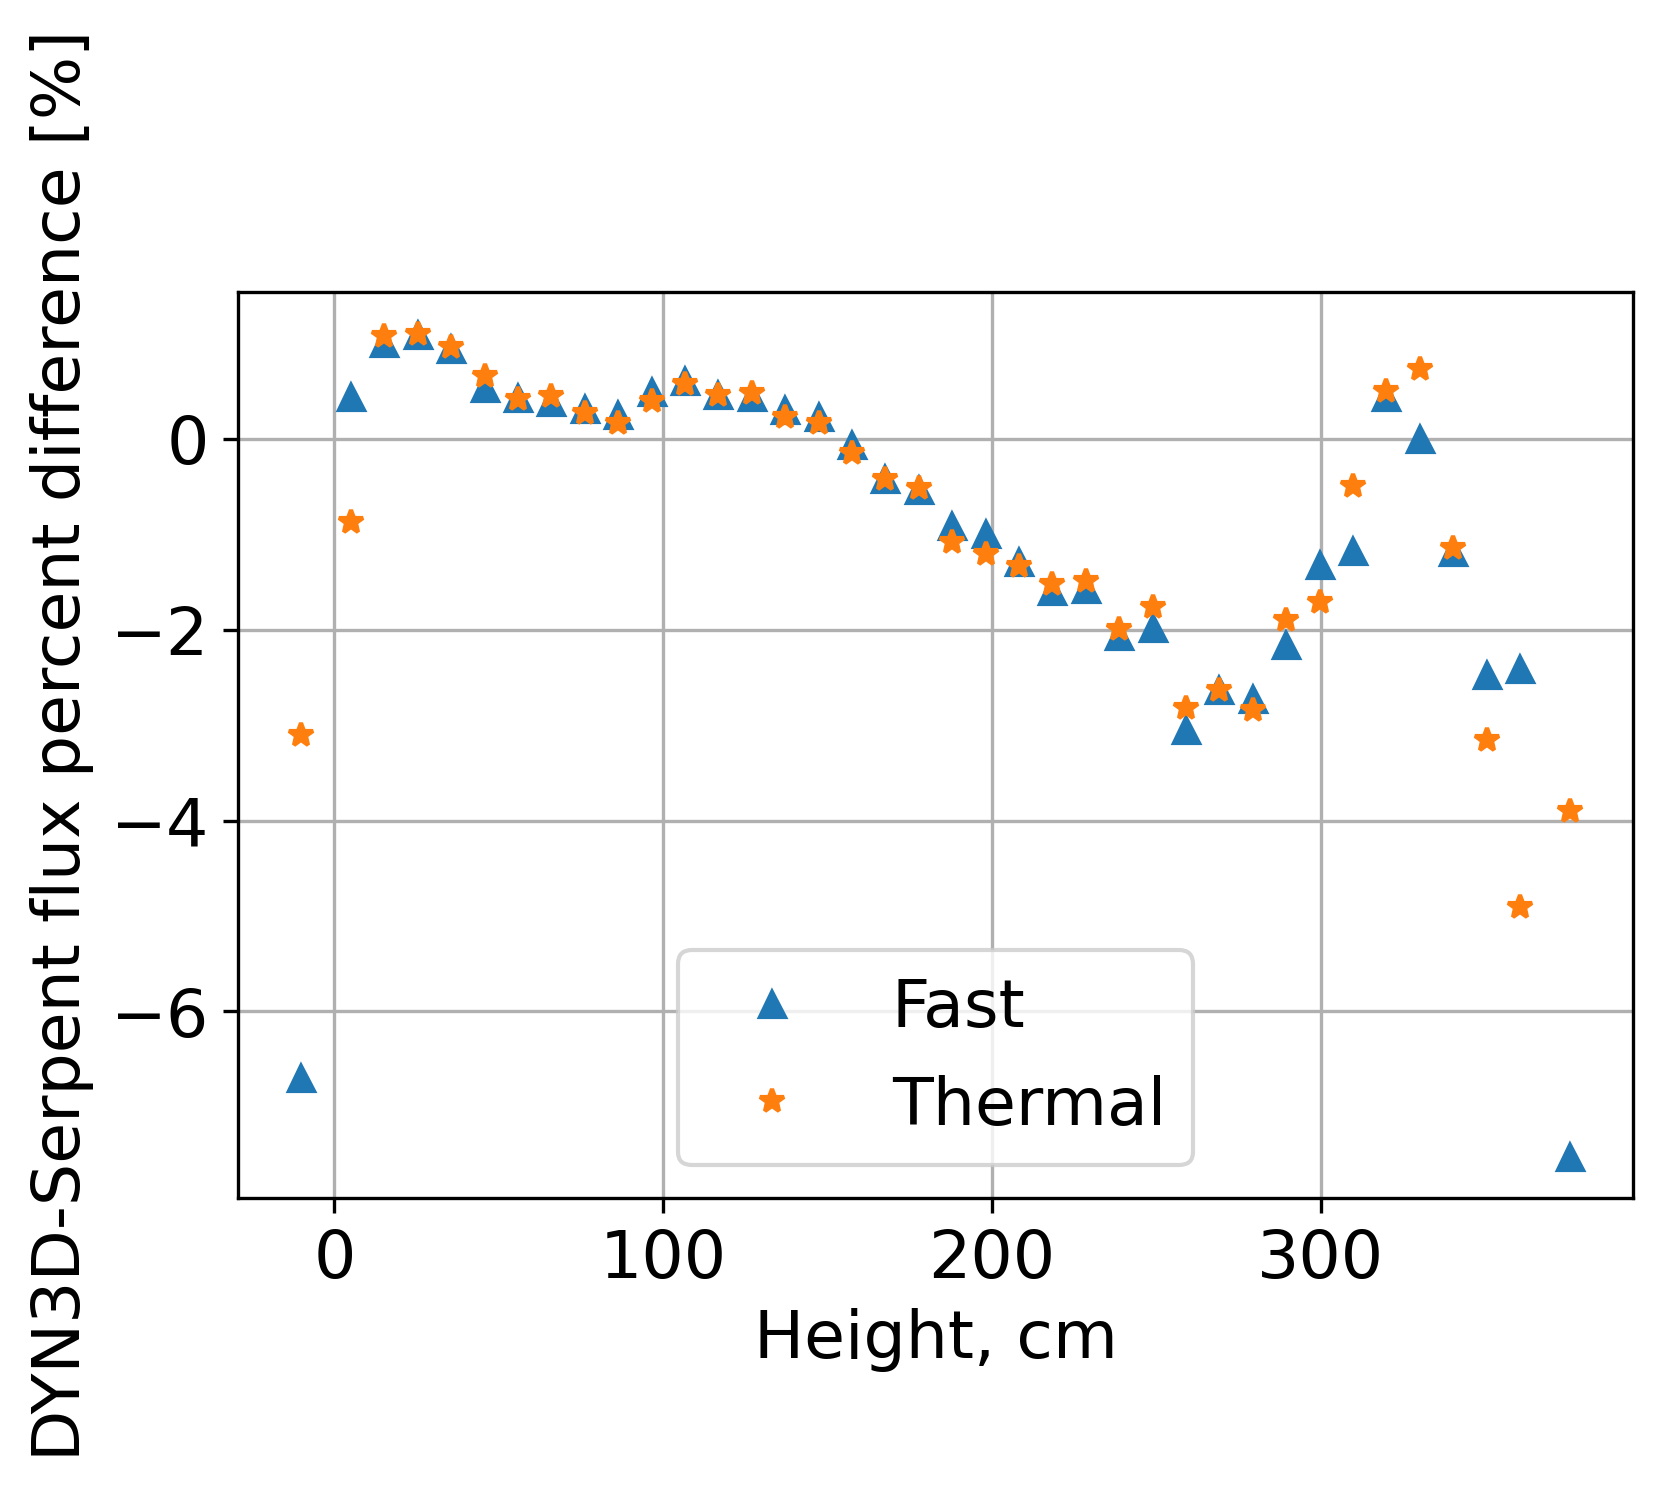

In [23]:
Plot1d(xvalues=zmid, yvalues=gr_diff,
       markers=['^', '*'],
       xlabel="Height, cm", ylabel="DYN3D-Serpent flux percent difference [%]")